# Introduction


The goal of this notebook is to demonstrate how to estimate biophysical variables from remote sensing.  The biophysical variables of interest include Leaf Area Index (LAI), fraction of Photosynthetically Active Radiation (fPAR), biomass, yield to name a few. As you may remember from previous classes, there are a number of different ways to get at these *continuous* variables.  In this notebook we will use regression and machine learning algorithms in regression mode to achive our goal.  The general steps are:
- acquire location specific biophysical variable measurements (e.g. LAI)
- acquire satellite reflectance data over the same location/time period
- build a regression model that explains the relationship between spectral reflectance and the biophysical variable
- apply the model to the reflectance image to produce a biopysical variable *map*

For this assignment, we are going to use MODIS LAI/fPAR product to extract LAI data at 500-meter spatial resolution.  We will then extract the Sentinel-2 MSI reflectance data that have been downscaled to 500-meter spatial resolution.  We will then build a relationship between MSI spectral bands and LAI and apply the regression model to a 10-meter MSI image to make a LAI map.  For your convenience, I used the following Google Earth Engine code to extract the LAI and MSI reflectance samples into a CSV file that we will work with: 
[GEE code](https://code.earthengine.google.com/c68270f84af46205122aab17ff8f1880?noload=1)


# Import libraries

Lets start by updating the operating system and installing rasterio. Some of the more niche packages have to be downloaded as they are not standard on collab

In [2]:
#These will update and install some of the packages required to run the following script
!add-apt-repository ppa:ubuntugis/ppa
!apt update
!apt install gdal-bin libgdal-dev# !pip3 install rasterio

 Official stable UbuntuGIS packages.


 More info: https://launchpad.net/~ubuntugis/+archive/ubuntu/ppa
Press [ENTER] to continue or Ctrl-c to cancel adding it.

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Ge

Now lets update the other packages we will be using throughout this code.
The packages are the basic ones required to work with data/dataframes, matplotlib, numpy and pandas. Rasterio allows us to work with the tiff image and the sklearns are the machine learning packages that will allow us to do the linear regression/ machine learning and test our models.

In [5]:
!pip3 install rasterio
import rasterio
from rasterio.plot import reshape_as_raster, reshape_as_image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

     |████████████████████████████████| 19.1MB 1.3MB/s 


# Grab data and explore

Lets grab a a single pixel time series data first.  It is contained in a comma separated file to be imported from a cloud location.

In [7]:
# read the csv file into a pandas series object
# header=0 tells pandas that the first row of the csv file contains the column headers
# squeeze=True means we only have one data column and that we are interested in a Series and not a DataFrame.
laiData = pd.read_csv('https://storage.googleapis.com/alexi_daily/EnvSt956/s2_lai_rand.csv', header=0, squeeze=True)

#the csv is writen into laiData and converted into a pandas dataframe
#the following line will show this 
df = laiData
print(type(laiData))

# let's explore the dataset
# peek at the data
print(df.head(10))

# Descriptive statistics
# This lets us quickly look at the data and make sure it is in the format 
# that we want it in and will allow us to find any scaling issues.
# It gives the count, mean, std, min and max for each column in the dataframe
print(df.describe())

# let's add simple ratio an NDVI
# Here we define
df['SR'] = df['nir']/df['red']
df['NDVI'] = (df['nir'] - df['red'])/(df['nir'] + df['red'])

# Descriptive statistics
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
   rand  blue  green   red   nir  swir1  swir2  LAI
0     1   664    814   878  2041   2393   1740   12
1     3   138    188   102  1066    504    277   23
2    12   251    462   217  5130   1883    822   29
3    14   265    527   274  4670   1816    801   43
4    21   380    586   416  3313   1843    930   17
5    24  1116   1450  1799  3301   4154   2918    4
6    31   326    590   393  4570   2266   1070   34
7    36   328    524   361  3535   2186   1171   22
8    40   432    649   478  4281   2008   1039   26
9    43   309    708   299  3769   1908    934   51
               rand          blue  ...         swir2           LAI
count  16932.000000  16932.000000  ...  16932.000000  16932.000000
mean   50030.296008    582.200035  ...   1637.589712     16.517777
std    28776.371810    554.804054  ...    797.850504     15.813860
min        1.000000      2.000000  ...     23.000000      1.000000
25%    25093.750000    327.000000  ...   1004.000000   


Now lets build a Linar model and a random forest classifier to predict LAI given just SR and compare it to the same models using all the bands we have availible

Linear regression SR Rsquare:  0.6425515519566362


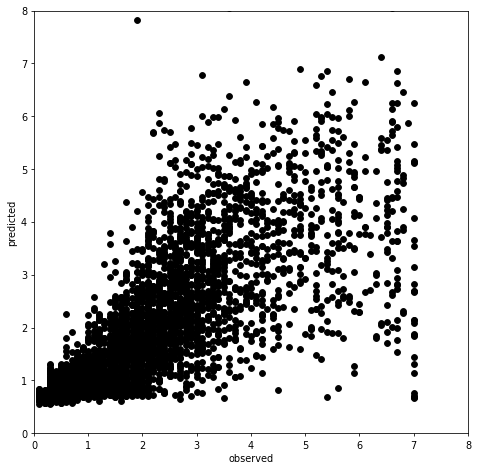

Linear regression all Rsquare:  0.7115059738444818


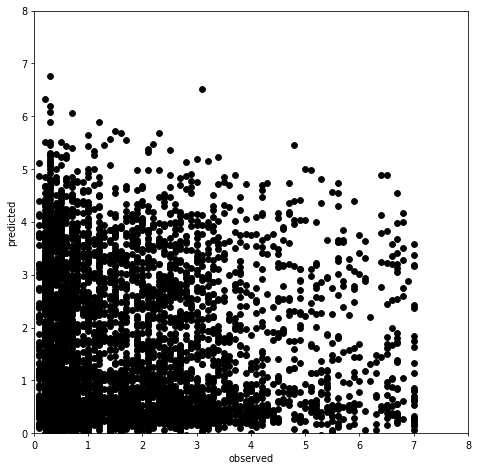

Lasso regression SR Rsquare:  0.6425535868353307


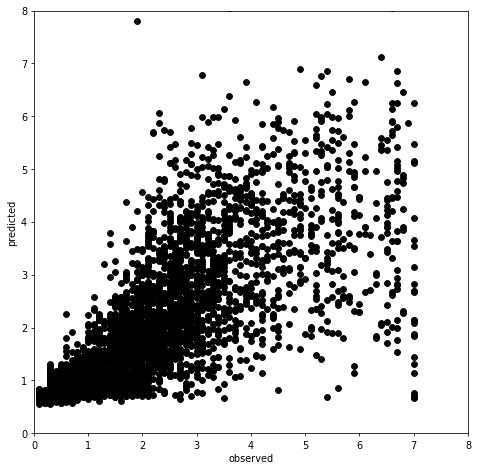

Lasso regression all Rsquare:  0.7114668161291245


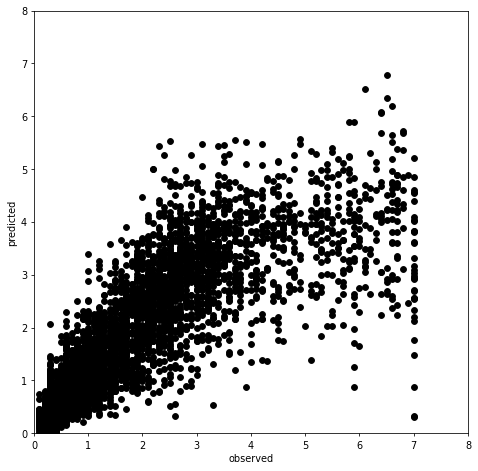

RF regression SR Rsquare:  0.6772393530006882


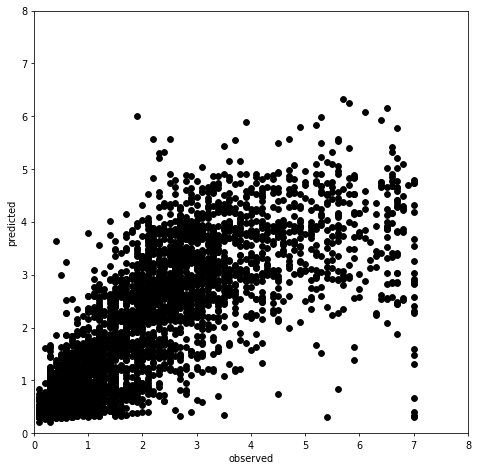

RF regression all Rsquare:  0.7210943208531146


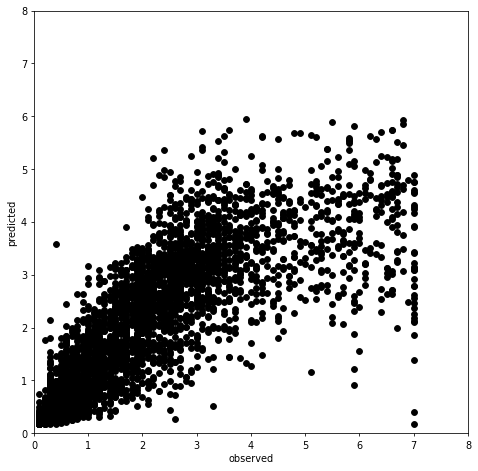

Accuracy Scores for all tests:
Linear regression SR Rsquare:  0.6425515519566362
Linear regression all Rsquare:  0.7115059738444818
Lasso regression SR Rsquare:  0.6425535868353307
Lasso regression all Rsquare:  0.7114668161291245
RF regression SR Rsquare:  0.6772393530006882
RF regression all Rsquare:  0.7210943208531146


In [8]:
# Test/train split
# note the selection of variable columns from a pandas DF - we use double [[]]
# because first [] is the select from DF and the second (inner) [] is the list 
# of columns to choose from

X = df[['SR']]
X_all = df[['blue','green','red','nir','swir1','swir2','SR','NDVI']].values
y = df['LAI'].values.reshape(-1,1).ravel()*0.1

# select train and test samples using 70% for training and 30% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3)
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y,test_size=0.3)

# LINEAR REGRESSION EXAMPLE
# build linear regression between SR and LAI
regLinear = LinearRegression().fit(X_train,y_train)
test_pred = np.array(regLinear.predict(X_test))
RMSE=np.sqrt(np.sum(np.square(test_pred-y_test)))
test_score_lr = regLinear.score(X_test,y_test)
print('Linear regression SR Rsquare: ',test_score_lr)

# Plot
plt.figure(figsize=(8, 8), dpi=70)
plt.axis([0, 8, 0, 8])
plt.plot(y_test,test_pred, 'o', color='black')
plt.xlabel('observed')
plt.ylabel('predicted')
plt.show()

regLinearall = LinearRegression().fit(X_train_all,y_train_all)
test_pred_all = np.array(regLinearall.predict(X_test_all))
RMSE=np.sqrt(np.sum(np.square(test_pred_all-y_test_all)))
test_score_lrall = regLinearall.score(X_test_all,y_test_all)
print('Linear regression all Rsquare: ',test_score_lrall)

# Plot
plt.figure(figsize=(8, 8), dpi=70)
plt.axis([0, 8, 0, 8])
plt.plot(y_test,test_pred_all, 'o', color='black')
plt.xlabel('observed')
plt.ylabel('predicted')
plt.show()


# LASSO REGRESSION EXAMPLE
# set lasso parameters
# Alpha (regularization strength) of LASSO regression
lasso_eps = 0.0001
lasso_nalpha=20
lasso_iter=5000

regLasso = LassoCV(eps=lasso_eps, n_alphas=lasso_nalpha, max_iter=lasso_iter, normalize=True, cv=5)
regLasso.fit(X_train,y_train)
test_pred = np.array(regLasso.predict(X_test))
RMSE=np.sqrt(np.sum(np.square(test_pred-y_test)))
test_scorel = regLasso.score(X_test,y_test)
print('Lasso regression SR Rsquare: ',test_scorel)

# Plot
plt.figure(figsize=(8, 8), dpi=70)
plt.axis([0, 8, 0, 8])
plt.plot(y_test,test_pred, 'o', color='black')
plt.xlabel('observed')
plt.ylabel('predicted')
plt.show()

regLasso = LassoCV(eps=lasso_eps, n_alphas=lasso_nalpha, max_iter=lasso_iter, normalize=True, cv=5)
regLasso.fit(X_train_all,y_train_all)
test_pred_all = np.array(regLasso.predict(X_test_all))
RMSE=np.sqrt(np.sum(np.square(test_pred_all-y_test_all)))
test_scorelall = regLasso.score(X_test_all,y_test_all)
print('Lasso regression all Rsquare: ',test_scorelall)

# Plot
plt.figure(figsize=(8, 8), dpi=70)
plt.axis([0, 8, 0, 8])
plt.plot(y_test_all,test_pred_all, 'o', color='black')
plt.xlabel('observed')
plt.ylabel('predicted')
plt.show()

# RANDOM FOREST EXAMPLE
# first establish the model parameters
regRF = RandomForestRegressor(max_depth=10, random_state=0)
regRF.fit(X_train, y_train)
test_pred = np.array(regRF.predict(X_test))
RMSE=np.sqrt(np.sum(np.square(test_pred-y_test)))
test_scorerf = regRF.score(X_test,y_test)
print('RF regression SR Rsquare: ',test_scorerf)

# Plot
plt.figure(figsize=(8, 8), dpi=70)
plt.axis([0, 8, 0, 8])
plt.plot(y_test,test_pred, 'o', color='black')
plt.xlabel('observed')
plt.ylabel('predicted')
plt.show()

regRF = RandomForestRegressor(max_depth=10, random_state=0)
regRF.fit(X_train_all, y_train_all)
test_pred_all = np.array(regRF.predict(X_test_all))
RMSE=np.sqrt(np.sum(np.square(test_pred_all-y_test_all)))
test_scorerfall = regRF.score(X_test_all,y_test_all)
print('RF regression all Rsquare: ',test_scorerfall)

# Plot
plt.figure(figsize=(8, 8), dpi=70)
plt.axis([0, 8, 0, 8])
plt.plot(y_test_all,test_pred_all, 'o', color='black')
plt.xlabel('observed')
plt.ylabel('predicted')
plt.show()

print("Accuracy Scores for all tests:")
print('Linear regression SR Rsquare: ',test_score_lr)
print('Linear regression all Rsquare: ',test_score_lrall)
print('Lasso regression SR Rsquare: ',test_scorel)
print('Lasso regression all Rsquare: ',test_scorelall)
print('RF regression SR Rsquare: ',test_scorerf)
print('RF regression all Rsquare: ',test_scorerfall)

As we can see from the accuracy scores, we are more accurate predicting LAI if we use more bands to do our analyisis. Of all our models the random forrest was the most accuract with both SR only and with all other bands with an accuracy of %69 and %72 respectivly. 

Now lets do image form

The following code block imports the image and converts it to a 2D array so we can work with it.

In [9]:
# read the SR image
!wget https://storage.googleapis.com/alexi_daily/EnvSt956/ia_sr_sample_image.tif ia_sr_sample_image.tif
srimage = rasterio.open('ia_sr_sample_image.tif').read()
[bands,rows,cols] = srimage.shape
print(bands)
print(rows)
print(cols)
srimage = srimage.reshape(bands*rows*cols).reshape(-1, 1) # collapse 3D array into a 2D array

--2021-01-25 23:22:30--  https://storage.googleapis.com/alexi_daily/EnvSt956/ia_sr_sample_image.tif
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 74.125.204.128, 64.233.187.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 320440755 (306M) [image/tiff]
Saving to: ‘ia_sr_sample_image.tif’

ia_sr_sample_image. 100%[===================>] 305.60M  26.0MB/s    in 12s     

2021-01-25 23:22:44 (26.0 MB/s) - ‘ia_sr_sample_image.tif’ saved [320440755/320440755]

--2021-01-25 23:22:44--  http://ia_sr_sample_image.tif/
Resolving ia_sr_sample_image.tif (ia_sr_sample_image.tif)... failed: Name or service not known.
wget: unable to resolve host address ‘ia_sr_sample_image.tif’
FINISHED --2021-01-25 23:22:44--
Total wall clock time: 13s
Downloaded: 1 files, 306M in 12s (26.0 MB/s)
1
7530
10886


The following code uses the SR only models above for linear regression and random forrest and creates and image for LAI using their predictions. Because the tiff we are working with only has the SR band we can only use it in our models to predict the LAI image. If we wanted to use other bands to predict LAI we would have to include them in the tiff as well.

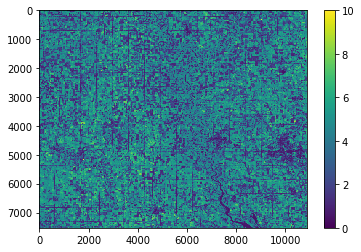

ValueError: ignored

In [10]:
# linear regression
LAI_preds = regLinear.predict(srimage)

LAI_preds = LAI_preds.reshape(rows,cols)
plt.imshow(LAI_preds, vmin = 0, vmax = 10, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.show()

# RF regression
LAI_preds_RF = regRF.predict(srimage)

LAI_preds_RF = LAI_preds_RF.reshape(rows,cols)
plt.imshow(LAI_preds_RF, vmin = 0, vmax = 10, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.show()


As we can see in the images above, both models create a similar classificaion visually though the random forrest is slightly darker accross the board.